In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance
from torch.utils.data import Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



class Cifar_Custom(Dataset):
    def __init__(self, data, transform, brighten=False):
        self.data = data
        self.transform = transform
        self.brighten = brighten

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        if self.brighten:
        
            image, label = self.data[idx]

            enhancer = ImageEnhance.Brightness(image)
            factor = torch.randint(5,16, (1,1), dtype=torch.float32)[0]*0.1
            image = enhancer.enhance(factor)

            if factor < 0.3: #anything less than 0.3 darkens the image completely
                factor[0] = 0.0

            image = self.transform(image)
            
            return image, label, factor
        
        else:

            image, label =  self.data[idx]
            return self.transform(image), label 

In [5]:
add_extra_class = True
use_brighten = True

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

Cifar_Custom_trainset = Cifar_Custom (trainset, transform=transform, brighten=True)

trainloader = torch.utils.data.DataLoader(Cifar_Custom_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

if add_extra_class == True:
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck','unknown')
else:
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


tensor([[1.0000],
        [0.8000],
        [1.3000],
        [0.6000]])


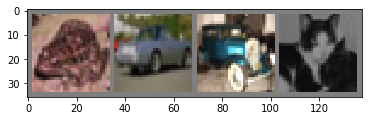

frog   car   car   cat


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
if use_brighten:
    images, labels, factor = dataiter.next()
    print (factor)
else:
    images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [8]:
device = 'cuda'
net = net.to(device=device)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
#Custom loss function to support one hot
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [11]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if use_brighten:
            inputs, labels, factor = data
        else:
            inputs, labels = data
            
        labels = labels.view(labels.size(0), 1)
        
        labels_onehot = torch.FloatTensor(inputs.size(0), len(classes))

        # In your for loop
        labels_onehot.zero_()
        labels_onehot.scatter_(1, labels, 1)

        if use_brighten:

            for i_example in range (inputs.size(0)):
                labels_onehot[i_example][labels[i_example]] = 1 - abs(1-factor[i_example])
                labels_onehot[i_example][10] = abs(1-factor[i_example])


        inputs = inputs.cuda()
        labels = labels.cuda()
        labels_onehot = labels_onehot.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = cross_entropy(outputs, labels_onehot)
        #loss = criterion(outputs, labels_onehot)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.233
[1,  4000] loss: 2.029
[1,  6000] loss: 1.887
[1,  8000] loss: 1.809
[1, 10000] loss: 1.769
[1, 12000] loss: 1.722
[2,  2000] loss: 1.650
[2,  4000] loss: 1.652
[2,  6000] loss: 1.612
[2,  8000] loss: 1.601
[2, 10000] loss: 1.585
[2, 12000] loss: 1.572
[3,  2000] loss: 1.533
[3,  4000] loss: 1.524
[3,  6000] loss: 1.497
[3,  8000] loss: 1.497
[3, 10000] loss: 1.481
[3, 12000] loss: 1.490
[4,  2000] loss: 1.444
[4,  4000] loss: 1.416
[4,  6000] loss: 1.435
[4,  8000] loss: 1.414
[4, 10000] loss: 1.421
[4, 12000] loss: 1.416
[5,  2000] loss: 1.354
[5,  4000] loss: 1.376
[5,  6000] loss: 1.374
[5,  8000] loss: 1.364
[5, 10000] loss: 1.375
[5, 12000] loss: 1.343
[6,  2000] loss: 1.318
[6,  4000] loss: 1.328
[6,  6000] loss: 1.329
[6,  8000] loss: 1.304
[6, 10000] loss: 1.326
[6, 12000] loss: 1.331
[7,  2000] loss: 1.274
[7,  4000] loss: 1.281
[7,  6000] loss: 1.300
[7,  8000] loss: 1.278
[7, 10000] loss: 1.296
[7, 12000] loss: 1.294
[8,  2000] loss: 1.238
[8,  4000] 

In [12]:
PATH = './cifar_net_bright_label.pth'
torch.save(net.state_dict(), PATH)


In [13]:
dataiter = iter(testloader)


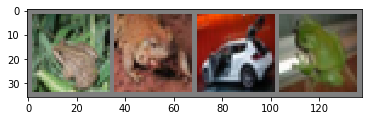

GroundTruth:   frog  frog   car  frog


In [19]:
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [20]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
outputs = net(images)

In [22]:

_, predicted = torch.max(outputs, 1)
print (outputs)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


tensor([[-3.7740,  0.1261, -1.4818,  2.6958,  3.3938, -1.2126,  3.8164, -3.6119,
         -1.8121, -1.3893,  3.7481],
        [-2.4120, -6.1128,  3.8689,  1.3743,  5.3506,  2.2996,  5.4277, -1.3169,
         -4.4044, -7.2648,  4.5716],
        [-6.1433,  3.4946,  3.1032,  1.4546, -2.0936,  3.1833, -2.0957,  0.1504,
         -5.6584,  3.1361,  4.0476],
        [ 1.4567, -2.8499,  4.9519,  2.1682,  4.3982, -0.8584,  6.5722, -5.5221,
         -4.6207, -6.9376,  5.3080]], grad_fn=<AddmmBackward>)
Predicted:   frog  frog unknown  frog


In [33]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        #Calculate top two Accuracy
        # max1_indices = torch.sort(outputs.data, descending=True).indices[:,0]
        # max2_indices = torch.sort(outputs.data, descending=True).indices[:,1]
        # total += labels.size(0)
        # correct += (max1_indices == labels).sum().item()
        # correct += (max2_indices == labels).sum().item()
        
        for ind in predicted: #lets check after taking out unknowns 
            if ind == 10:
                total -= 1

        # for ind in max2_indices:
        #     if ind == 10:
        #         #print ('max2',total,correct)
        #         total -= 1
        
        
        

print (total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

9388
Accuracy of the network on the 10000 test images: 64 %


In [44]:
max1_indices = torch.sort(outputs.data, descending=True).indices[:,0]
max2_indices = torch.sort(outputs.data, descending=True).indices[:,1]

In [49]:
print (max1_indices == labels)

tensor([ True,  True, False,  True])


In [43]:
max_indices

tensor([3, 8, 1, 0])